In [ ]:
pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
mkdir ~/.kaggle

In [4]:
! cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download masoudnickparvar/brain-tumor-mri-dataset

100% 148M/149M [00:08<00:00, 19.2MB/s]
100% 149M/149M [00:08<00:00, 18.5MB/s]


In [7]:
! unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [8]:
# loading necessary imports
import os
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping

'modules loaded successfully'

'modules loaded successfully'

###Now we have the required modules loaded and the next step is to load data into training and test dataframe for further analysis

In [9]:
training_df_path="/content/Training" # loading training data into dataframe
labels=[]
filepaths=[]

folds=os.listdir(training_df_path)
for fold in folds:
    folderPath=os.path.join(training_df_path,fold)
    folderList=os.listdir(folderPath)
    for file in folderList:
        filepath=os.path.join(folderPath,file)

        labels.append(fold)
        filepaths.append(filepath)


labelsSeries=pd.Series(labels,name="labels")
fileSeries=pd.Series(filepaths,name="filepaths")

training_df=pd.concat([fileSeries,labelsSeries],axis=1)

training_df

,filepaths,labels
0,/content/Training/pituitary/Tr-pi_0879.jpg,pituitary
1,/content/Training/pituitary/Tr-pi_1148.jpg,pituitary
2,/content/Training/pituitary/Tr-piTr_0009.jpg,pituitary
3,/content/Training/pituitary/Tr-pi_0741.jpg,pituitary
4,/content/Training/pituitary/Tr-pi_0510.jpg,pituitary
...,...,...
5707,/content/Training/meningioma/Tr-me_1152.jpg,meningioma
5708,/content/Training/meningioma/Tr-me_0022.jpg,meningioma
5709,/content/Training/meningioma/Tr-me_1336.jpg,meningioma
5710,/content/Training/meningioma/Tr-me_1228.jpg,meningioma


In [10]:
testing_df_path="/content/Testing" # loading test data into dataframe
labels=[]
filepaths=[]

folders=os.listdir(testing_df_path)
for fold in folds:
    folderPath=os.path.join(testing_df_path,fold)
    folderList=os.listdir(folderPath)
    for file in folderList:
        filepath=os.path.join(folderPath,file)

        labels.append(fold)
        filepaths.append(filepath)

labelsSeries=pd.Series(labels,name="labels")
fileSeries=pd.Series(filepaths,name="filepaths")

testing_df=pd.concat([fileSeries,labelsSeries],axis=1)

testing_df

,filepaths,labels
0,/content/Testing/pituitary/Te-pi_0174.jpg,pituitary
1,/content/Testing/pituitary/Te-pi_0233.jpg,pituitary
2,/content/Testing/pituitary/Te-pi_0068.jpg,pituitary
3,/content/Testing/pituitary/Te-pi_0176.jpg,pituitary
4,/content/Testing/pituitary/Te-pi_0086.jpg,pituitary
...,...,...
1306,/content/Testing/meningioma/Te-me_0227.jpg,meningioma
1307,/content/Testing/meningioma/Te-me_0065.jpg,meningioma
1308,/content/Testing/meningioma/Te-me_0135.jpg,meningioma
1309,/content/Testing/meningioma/Te-me_0252.jpg,meningioma


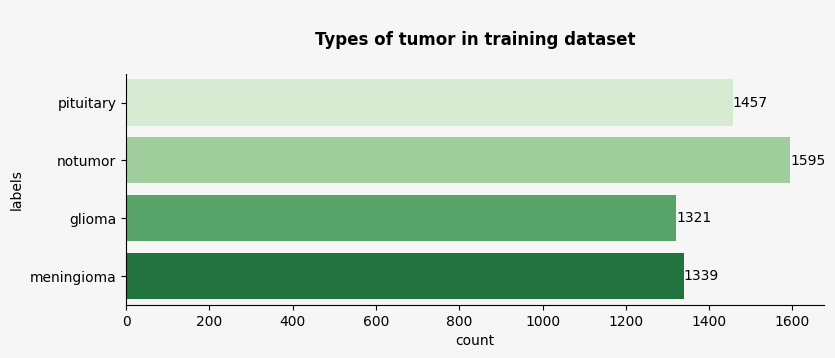

In [11]:
fgre,axis=plt.subplots(figsize=(9, 3)) # plot the types of tumor
fgre.patch.set_facecolor("#f6f6f7")
axis.set_facecolor("#f6f6f7")
for i in ["top","right"]:
    axis.spines[i].set_visible(False)

x = sns.countplot(data=training_df, y=training_df.labels, palette='Greens')
for container in x.containers:
    x.bar_label(container)
plt.title("\nTypes of tumor in training dataset\n", weight="bold");

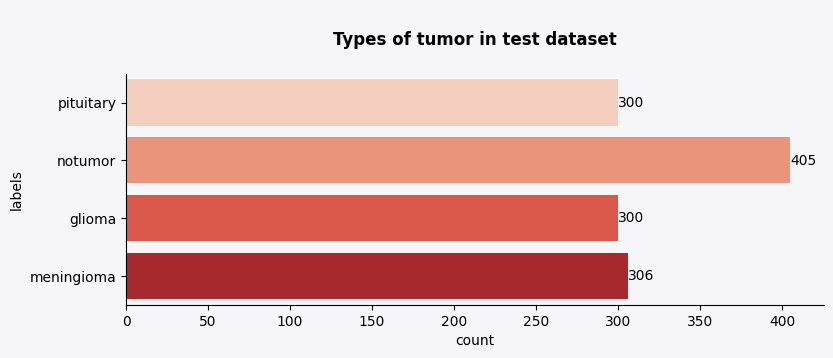

In [12]:
fgre,axis=plt.subplots(figsize=(9,3)) # plot the types of tumor
fgre.patch.set_facecolor("#f6f5f7")
axis.set_facecolor("#f6f5f7")
for i in ["right","top"]:
    axis.spines[i].set_visible(False)

i=sns.countplot(data=testing_df,y=testing_df.labels,palette='Reds')
for container in i.containers:
    i.bar_label(container)

plt.title("\nTypes of tumor in test dataset\n", weight="bold");

In [13]:
print(f'Shape for test dataframe {testing_df.shape}\n')
print(f'Shape for training dataframe {training_df.shape}')

Shape for test dataframe (1311, 2)

Shape for training dataframe (5712, 2)


In [11]:
print('Distribute dataframe into train, valid, and test for further analysis\n')
validation_df,testing_df=train_test_split(testing_df,test_size=0.5,random_state=50,stratify=testing_df.labels)

print(f"validation data shape: {validation_df.shape}")
print(f"testing data shape: {testing_df.shape}")
print("Validation data frame as below\n")
validation_df

Distribute dataframe into train, valid, and test for further analysis

validation data shape: (655, 2)
testing data shape: (656, 2)
Validation data frame as below



,filepaths,labels
318,/content/Testing/notumor/Te-no_0293.jpg,notumor
264,/content/Testing/pituitary/Te-pi_0164.jpg,pituitary
1088,/content/Testing/meningioma/Te-me_0211.jpg,meningioma
979,/content/Testing/glioma/Te-glTr_0003.jpg,glioma
502,/content/Testing/notumor/Te-no_0350.jpg,notumor
...,...,...
1308,/content/Testing/meningioma/Te-me_0135.jpg,meningioma
132,/content/Testing/pituitary/Te-pi_0077.jpg,pituitary
379,/content/Testing/notumor/Te-no_0123.jpg,notumor
693,/content/Testing/notumor/Te-no_0093.jpg,notumor


##Data Augmentation: Setup image data generator for training, testing and validation

In [12]:
img_size=(125,125) # set the image size

training=ImageDataGenerator()
testing=ImageDataGenerator()

training_gen=training.flow_from_dataframe(training_df,x_col="filepaths",y_col="labels",
                                 target_size=img_size,
                                 batch_size=16,shuffle=True,
                                 class_mode='categorical',color_mode="rgb")


validation_gen=testing.flow_from_dataframe(testing_df,x_col='filepaths',y_col='labels',
                                target_size=img_size,
                                 class_mode="categorical",color_mode="rgb",
                                 shuffle=True,batch_size=16)


testing_gen=testing.flow_from_dataframe(testing_df, x_col='filepaths', y_col='labels',
                                 target_size=img_size,
                                 batch_size=16, shuffle=False,
                                 color_mode="rgb", class_mode="categorical")


Found 5712 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


##Plot images from training dataset


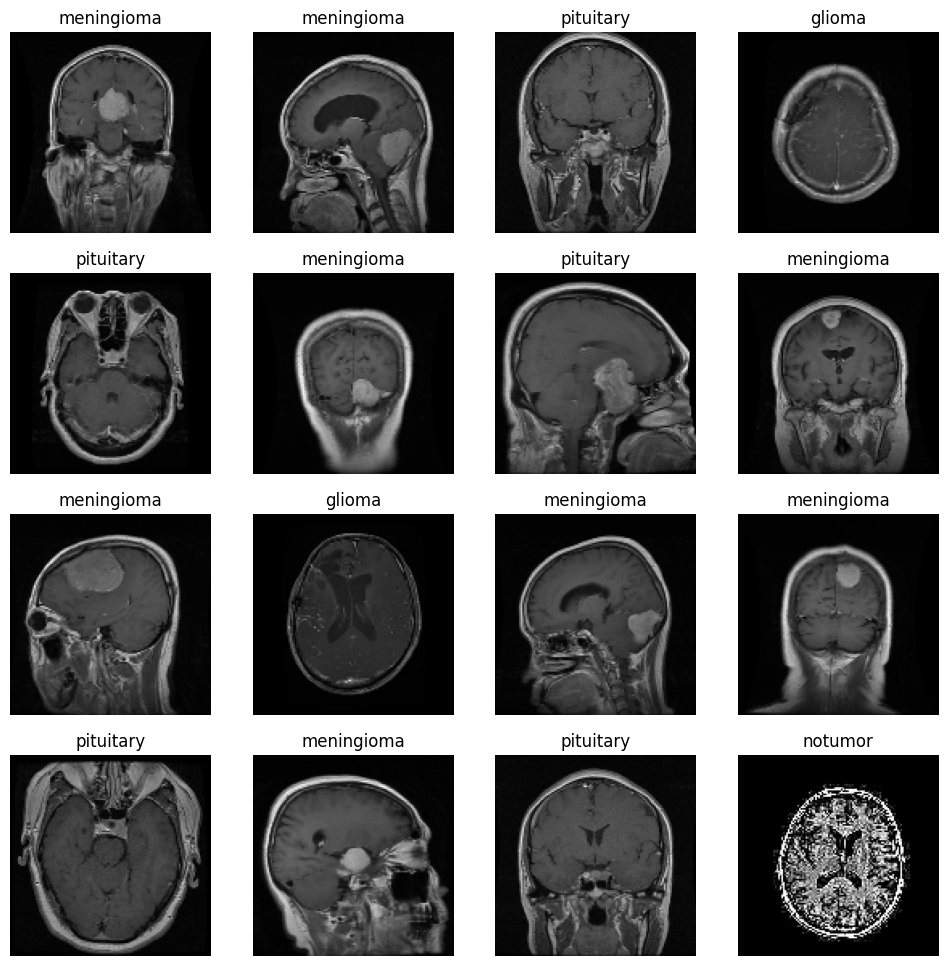

In [16]:
gen_dict = training_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(training_gen)

plt.figure(figsize= (12,12))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'black' , fontsize= 12,weight="normal")
    plt.axis('off')
plt.show()

###Plot images from test dataset

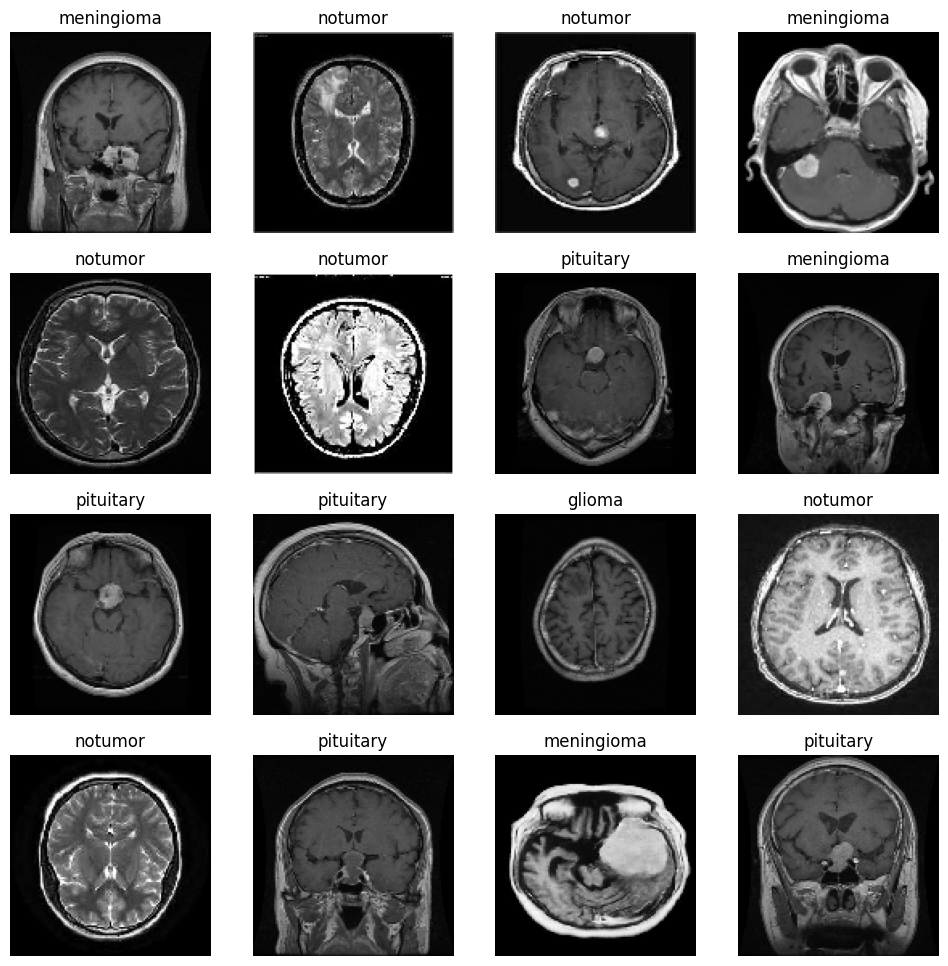

In [17]:
gen_dict = testing_gen.class_indices
classes = list(gen_dict.keys())
images, labels = next(testing_gen)

plt.figure(figsize= (12,12))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'black' , fontsize= 12,weight="normal")
    plt.axis('off')
plt.show()

###Plot images from validation dataset

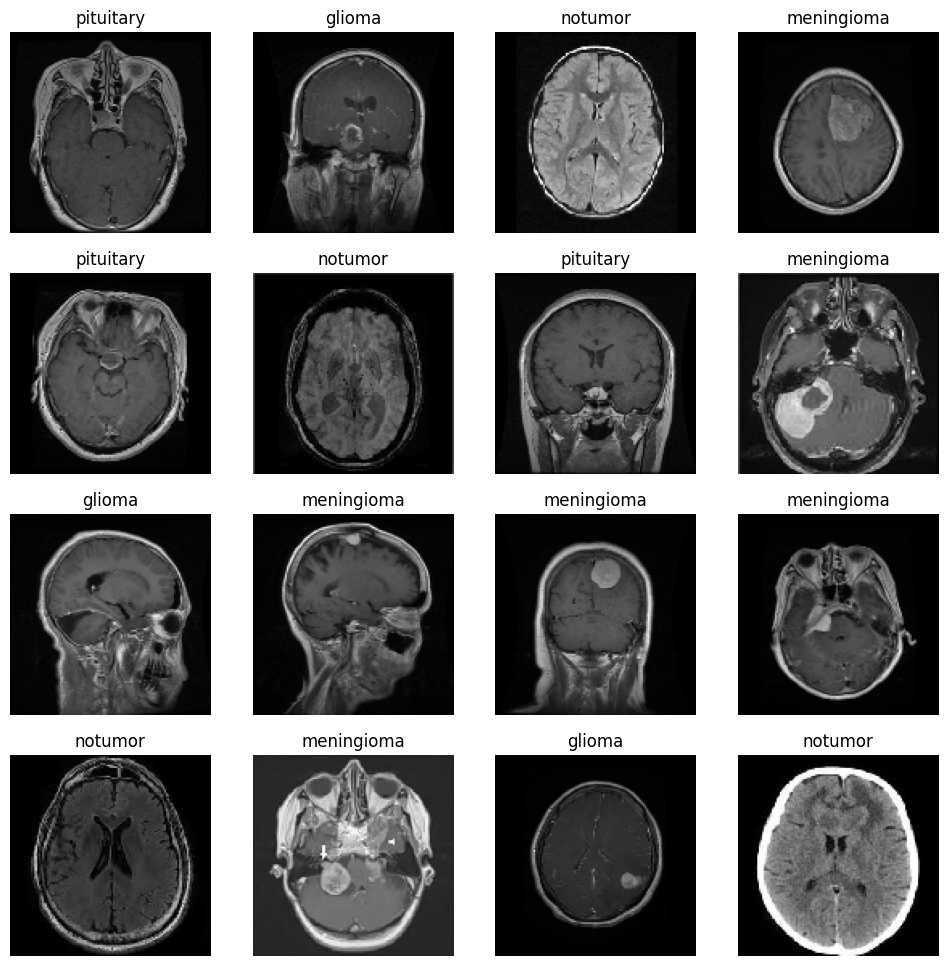

In [18]:
gen_dict = validation_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(validation_gen)

plt.figure(figsize= (12,12))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'black' , fontsize= 12,weight="normal")
    plt.axis('off')
plt.show()

##Setting up Deep Learning Model with Keras

In [13]:
img_shape=(125,125,3) # width, height, dimensions
basic_Model = tf.keras.applications.Xception(include_top= False,weights= "imagenet",
                                            input_shape= img_shape, pooling= 'max')

# Setup early stopping condition
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    min_delta=0.001,  # Minimum change to qualify as an improvement
    patience=10,  # How many epochs to wait before stopping
    verbose=1,
    mode='min',  # Stop when the quantity monitored has stopped decreasing
    restore_best_weights=True  # Restores model weights from the epoch with the minimum validation loss
)

model = Sequential([
    basic_Model,
    Dropout(rate= 0.5),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'],
              run_eagerly=True)

model.build()

model.summary()

83683744/83683744 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21124268 (80.58 MB)
Trainable params: 21069740 (80.37 MB)
Non-trainable params: 54528 (213.00 KB)
___________

### Printing the layers inside model

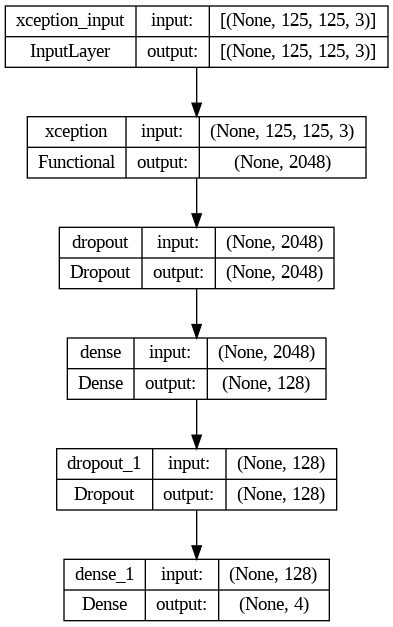

In [20]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [14]:
tf.config.run_functions_eagerly(True)
model_fit=model.fit(
    training_gen,
    validation_data=validation_gen,
    epochs=10,  # setting up a high number, as early stopping will pause the training
    batch_size=25,
    workers=4,  # based on the system's capabilities
    use_multiprocessing=True,
    callbacks=[early_stopping]
)

Epoch 1/10
357/357 [==============================] - 206s 559ms/step - loss: 0.3539 - accuracy: 0.8750 - val_loss: 0.1003 - val_accuracy: 0.9665
Epoch 2/10
357/357 [==============================] - 199s 557ms/step - loss: 0.1159 - accuracy: 0.9608 - val_loss: 0.0934 - val_accuracy: 0.9771
Epoch 3/10
357/357 [==============================] - 205s 571ms/step - loss: 0.0650 - accuracy: 0.9806 - val_loss: 0.0514 - val_accuracy: 0.9817
Epoch 4/10
357/357 [==============================] - 204s 569ms/step - loss: 0.0354 - accuracy: 0.9891 - val_loss: 0.0336 - val_accuracy: 0.9939
Epoch 5/10
357/357 [==============================] - 218s 609ms/step - loss: 0.0256 - accuracy: 0.9923 - val_loss: 0.0401 - val_accuracy: 0.9939
Epoch 6/10
357/357 [==============================] - 205s 573ms/step - loss: 0.0228 - accuracy: 0.9933 - val_loss: 0.0385 - val_accuracy: 0.9924
Epoch 7/10
357/357 [==============================] - 205s 573ms/step - loss: 0.0189 - accuracy: 0.9949 - val_loss: 0.0342 -

##Plotting the model performance


The model.save_weights("model.h5") command in TensorFlow/Keras is used to save the weights of our model to a file. This is particularly useful for saving the learned parameters of our model for later use.

In [15]:
json_model = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(json_model)

# save full weights to HDF5
model.save("model_full.h5")
"Saved model to disk successfully"

'Saved model to disk successfully'

In [16]:
from tensorflow.keras.models import load_model

model = load_model("model_full.h5")  # Load the full model

In [17]:
model_fit.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

<Figure size 2000x800 with 0 Axes>

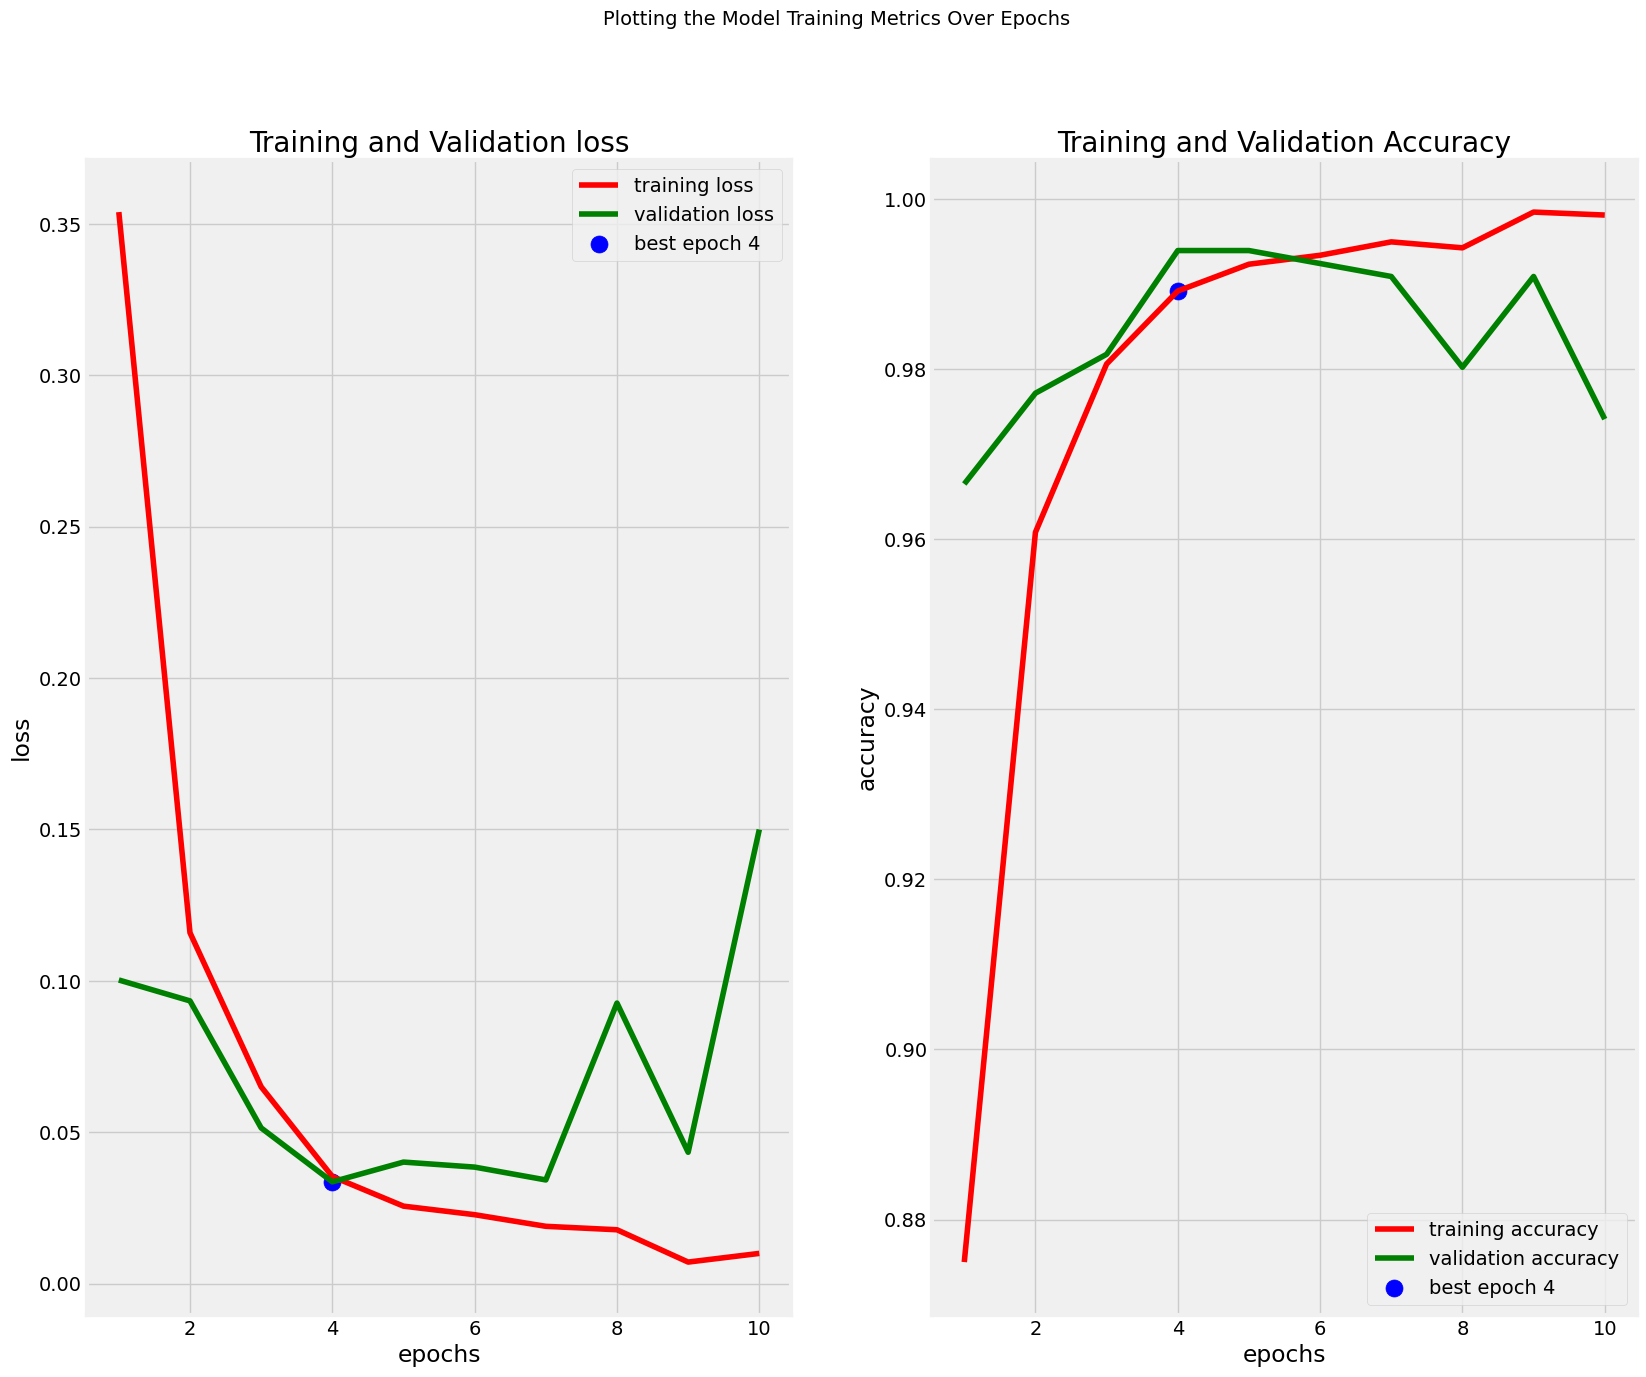

In [18]:
plt.figure(figsize=(20, 8))

# training data loss
training_loss=model_fit.history["loss"]
value_loss=model_fit.history["val_loss"]
index_loss=np.argmin(value_loss)
loss_lowest=value_loss[index_loss]
loss_label=f"best epoch {index_loss+1}"

# training data accuracy
training_accuracy=model_fit.history["accuracy"]
value_accuracy=model_fit.history["val_accuracy"]
index_acc=np.argmax(value_accuracy)
acc_highest=training_accuracy[index_acc]
accuracy_label=f"best epoch {index_acc+1}"

epochs=[i+1 for i in range (len(training_accuracy))]


plt.figure(figsize=(20,15))
plt.style.use('fivethirtyeight')

# plot training loss vs validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs,training_loss,"r",label="training loss")
plt.plot(epochs,value_loss,"g",label="validation loss")
plt.scatter(index_loss+1,loss_lowest,c="b",s=150,label=loss_label)
plt.title('Training and Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

# plot training accuracy vs validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs,training_accuracy,"r",label="training accuracy")
plt.plot(epochs,value_accuracy,"g",label="validation accuracy")
plt.scatter(index_acc+1,acc_highest,c="b",s=150,label=accuracy_label)
plt.title('Training and Validation Accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()


plt.suptitle('Plotting the Model Training Metrics Over Epochs', fontsize=14);

##Perform the Model Evaluation step

In [19]:
training_score=model.evaluate(training_gen)
validation_score=model.evaluate(validation_gen)
testing_score=model.evaluate(testing_gen)

print(f"Training Loss : {training_score[0]:.3f}")
print(f"Training Accuracy : {training_score[1]*100:.2f}%")
print("-"*40)
print(f"Validation Loss : {validation_score[0]:.3f}")
print(f"Validation Accuracy : {validation_score[1]*100:.2f}%")
print("-"*40)
print(f"Testing Loss: {testing_score[0]:.3f}")
print(f"Testing Accuracy: {testing_score[1]*100:.2f}%")

41/41 [==============================] - 6s 139ms/step - loss: 0.1500 - accuracy: 0.9741
Training Loss : 0.013
Training Accuracy : 99.70%
----------------------------------------
Validation Loss : 0.150
Validation Accuracy : 97.41%
----------------------------------------
Testing Loss: 0.150
Testing Accuracy: 97.41%


##Perform the predictive Analysis

In [20]:
preds=model.predict(testing_gen) # generate prediction using test data generator
y_pred=np.argmax(preds,axis=1)

41/41 [==============================] - 7s 162ms/step


###Plot the Confusion Matrics and display Classification Report

A confusion matrix is for summarizing the performance of a classification algorithm. It provides insights into the types and rates of errors made by the model.

**Confusion Matrix Interpretation**: Every row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class. The diagonal elements will represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled through the classifier.

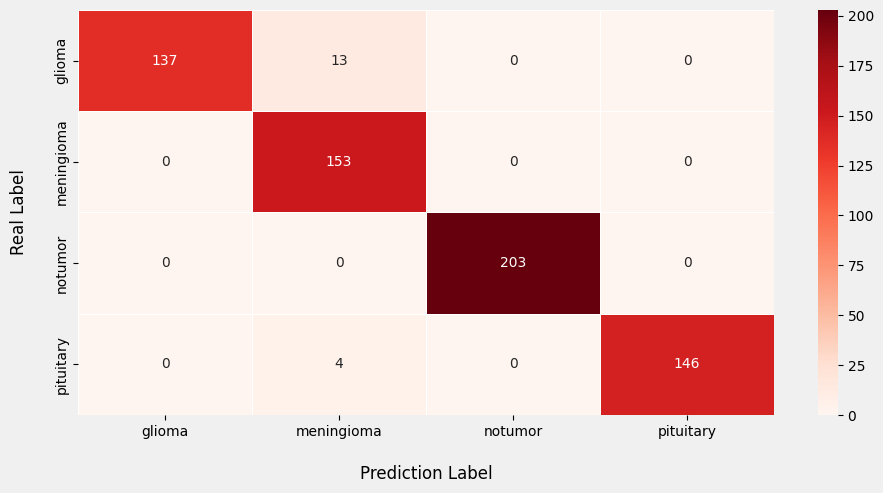

In [21]:
plt.figure(figsize=(10,5))
plt.style.use('default')
cm=confusion_matrix(testing_gen.classes,y_pred)
labels = list(testing_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Reds", linewidths=.5)
plt.xlabel('\nPrediction Label',fontsize=12)
plt.ylabel('Real Label\n',fontsize=12);

In [22]:
cr=classification_report(testing_gen.classes,y_pred) # print the classification report from test dataset
print(cr)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       150
           1       0.90      1.00      0.95       153
           2       1.00      1.00      1.00       203
           3       1.00      0.97      0.99       150

    accuracy                           0.97       656
   macro avg       0.97      0.97      0.97       656
weighted avg       0.98      0.97      0.97       656

